In [1]:
# Colab was used for this notebook hence the library installs
%%capture
!pip install pycaret --quiet --upgrade
!pip install dabl --quiet --upgrade
!pip install shap --quiet --upgrade
!pip install sdv  --quiet --upgrade
!pip install sdv[ctgan] --quiet --upgrade
!pip install baytune --quiet --upgrade
!pip install optuna --quiet --upgrade

UsageError: Line magic function `%%capture` not found.


## **Why this was done**
1. Learn about synthetic data generation and see if it can improve a model
2. Work with PyCaret on a classification problem
3. Work on an insurance related problem (although ficticious data)

## **The data**
Insurance data isn't easy to find given the nature of the data. However there are [fictious data](https://www.kaggle.com/pavansubhasht/ibm-hr-analytics-attrition-dataset) around which class of amount of the insurance given data below.

* ` age `
* ` bmi `
* ` children `
* ` sex `
* ` smoker `
* ` region `

The target value is 0, 1, 2, 3 such that higher number represents a higher range of insurance. 

The amount of data for each target value is approximately the same.

Throughout the dataset, we are using **Gausian Copula**

# **Libraries**

In [28]:
from pycaret.classification import * 
#from pycaret.regression import * # Preprocessing, modelling, interpretation, deployment...
from sklearn.impute import SimpleImputer
import pandas as pd # Basic data manipulation
#import dabl as db # Summary plot
from sklearn.model_selection import train_test_split # Data split
from sdv.tabular import CopulaGAN, GaussianCopula, CTGAN # Synthetic data
from sdv.evaluation import evaluate # Evaluate synthetic data
from btb.tuning import Tunable, GCPTuner # CopulaGAN optimising
from btb.tuning import hyperparams as hp  # Set hyperparameters for optimising
import joblib # Saving preparation steps
import sdv.constraints as cons # Evaluate synthetic data

# **Importing data**

In [29]:
# Read and output the top 5 rows
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
train.head()

,age,sex,bmi,children,smoker,region,charges
0,59,female,27.72,3,no,southeast,2
1,60,male,25.74,0,no,southeast,2
2,28,female,34.77,0,no,northwest,0
3,19,female,28.40,1,no,southwest,0
4,45,male,27.50,3,no,southwest,1


We first transform the regression problem into a classification problem. We split the data with respect to four quantiles. Therefore, the number of for each label of charges is roughly the same..

A fairly simply ordering per feature. 


Now feature(s) can be initialised
* Target feature
* Continuous features
* Ordinal features
* Categorical features
* Features to ignore

In [30]:
# Target feature
target = "charges"

# Continuous/numeric features
cont_feats = ["age", "bmi"]

# Ordinal features
ord_feats = {"children" : ["0", "1", "2", "3", "4", "5"]}

# Categorical geatures
cat_feats = ["region", "smoker", "sex"]

In [31]:
train

,age,sex,bmi,children,smoker,region,charges
0,59,female,27.720,3,no,southeast,2
1,60,male,25.740,0,no,southeast,2
2,28,female,34.770,0,no,northwest,0
3,19,female,28.400,1,no,southwest,0
4,45,male,27.500,3,no,southwest,1
...,...,...,...,...,...,...,...
797,18,female,31.350,4,no,northeast,0
798,39,female,23.870,5,no,southeast,1
799,58,male,25.175,0,no,northeast,2
800,37,female,47.600,2,yes,southwest,3


# **Generating synthetic data, Round one** 
# **Naive Generating**
There's a useful library `sdev` [Synthetic Data Generation](https://github.com/sdv-dev/SDV) to generate synthetic tabular data. I've played around with it specifically the `GaussianCopula` model.

The general idea is to provide a `primary key` and to then run the model for so many `epochs`. There are hyperparameters to tune
* `epochs`
* `batch_size`
* `embedding_dim`
* `gen_dim`
* `dis_dim`
* `l2scale` (omitted in this experiment)

Also we have constaints for the models to make data reasonable.

In [32]:
def MAXINT(a,b): return (abs(a-b)+(a+b))//2

def MAX(a,b): return (abs(a-b)+(a+b))/2

def MININT(a,b): return (-abs(a-b)+(a+b))//2

def MIN(a,b): return (-abs(a-b)+(a+b))/2

def over_18(data): return MAXINT(data["age"],18)

age_constraint = cons.ColumnFormula(column = 'age',
                                    formula = over_18,
                                    handling_strategy = 'reject_sampling')

def children_range(data): return MININT(MAXINT(data["children"],0),5)

children_constraint = cons.ColumnFormula(column = 'children',
                                         formula = children_range,
                                         handling_strategy = 'reject_sampling')

min_bmi = min(train["bmi"])
max_bmi = max(train["bmi"])

def bmi_range(data): return MIN(MAX(data["bmi"],min_bmi),max_bmi)

bmi_constraint = cons.ColumnFormula(column = 'bmi',
                                    formula = bmi_range,
                                    handling_strategy = 'reject_sampling')

min_charges= min(train["charges"])
max_charges = max(train["charges"])

def charges_range(data): return MIN(MAX(data["charges"],min_charges*0.8),max_charges*1.25)

charges_constraint = cons.ColumnFormula(column = 'charges',
                                    formula = charges_range,
                                    handling_strategy = 'reject_sampling')

def charges_range_truncated(data): return MIN(MAX(data["charges"],12000),max_charges*1.25)

charges_constraint_2 = cons.ColumnFormula(column = 'charges',
                                    formula = charges_range_truncated,
                                    handling_strategy = 'reject_sampling')

In [33]:
import time
best_score = 0 # Keep track of best score
best_data = None
tracker = 0 # Keep track of how many loops have completed
flag = True
scores=[]

real = train # Filter to only those employees that left
ST = time.time()
## TRAINING LOOP START ##
for _ in range(30): # only 1 and do the test

    # Increment the tracker
    tracker += 1
  
    # Every 5 loops output the tracker -> 1 loop
    print(tracker)

    # Get the hyperparameters for this loop
    #proposal = tuner.propose(1)
  
    # Create the CopulaGAN -> GAussianCopu;a
    # NOTE - batch_size is multiplied by 10 as needs to be a factor of 10
    model = GaussianCopula(constraints = [age_constraint, children_constraint, bmi_constraint])
    
    
    # Fit the CTGAN
    model.fit(real)
    distributions = model.get_distributions()
    # Create 600 rows of data
    synth_data = model.sample(num_rows = 600)
  
    # Evaluate the synthetic data against the real data
    score = evaluate(synthetic_data = synth_data, real_data = real)
    scores.append(score)

    print(score)
    # If the new hyperparameters beat the best ones, store them along with the score
    if score > best_score or flag:
        flag = False
        best_data = synth_data
        #best_params = proposal
        best_score = score
  


## TRAINING LOOP END ##
ED=time.time()
print((ED-ST)/60,"minutes")

1
0.5143174400000343
2
0.5205171744498471
3
0.5191379968290843
4
0.5267033633978933
5
0.5129528801433969
6
0.5180928855667545
7
0.5203527561054082
8
0.518912390878246
9
0.517439334741484
10
0.525950737410009
11
0.5204549832616597
12
0.5104629255234598
13
0.5144526484307996
14
0.5128562373795144
15
0.5102081872467261
16
0.5096428695394455
17
0.5139689193179094
18
0.5091355366396031
19
0.5222929124685683
20
0.520341012715276
21
0.5178970207778486
22
0.5139905532273406
23
0.5225355027318769
24
0.5121546500142606
25
0.5168131030667515
26
0.5100663164688881
27
0.510085070351272
28
0.5194072803671173
29
0.5258143302093184
30
0.5210723381349663
4.063682226339976 minutes


In [34]:
distributions

{'age': 'copulas.univariate.beta.BetaUnivariate',
 'bmi': 'copulas.univariate.gamma.GammaUnivariate',
 'children': 'copulas.univariate.student_t.StudentTUnivariate',
 'charges': 'copulas.univariate.gaussian.GaussianUnivariate',
 'sex#0': 'copulas.univariate.gaussian.GaussianUnivariate',
 'sex#1': 'copulas.univariate.gaussian.GaussianUnivariate',
 'smoker#0': 'copulas.univariate.gamma.GammaUnivariate',
 'smoker#1': 'copulas.univariate.log_laplace.LogLaplace',
 'region#0': 'copulas.univariate.gaussian.GaussianUnivariate',
 'region#1': 'copulas.univariate.log_laplace.LogLaplace',
 'region#2': 'copulas.univariate.gaussian.GaussianUnivariate',
 'region#3': 'copulas.univariate.log_laplace.LogLaplace'}

In [35]:
score = evaluate(synthetic_data = best_data, real_data = real, aggregate = False)
score

,metric,name,raw_score,normalized_score,min_value,max_value,goal
0,BNLogLikelihood,BayesianNetwork Log Likelihood,-2.328926,0.097400,-inf,0.0,MAXIMIZE
1,LogisticDetection,LogisticRegression Detection,0.361377,0.361377,0.0,1.0,MAXIMIZE
2,SVCDetection,SVC Detection,0.295060,0.295060,0.0,1.0,MAXIMIZE
11,GMLogLikelihood,GaussianMixture Log Likelihood,-39453.435662,0.000000,-inf,inf,MAXIMIZE
12,CSTest,Chi-Squared,0.842801,0.842801,0.0,1.0,MAXIMIZE
13,KSTest,Inverted Kolmogorov-Smirnov D statistic,0.862340,0.862340,0.0,1.0,MAXIMIZE
14,KSTestExtended,Inverted Kolmogorov-Smirnov D statistic,0.835334,0.835334,0.0,1.0,MAXIMIZE
27,ContinuousKLDivergence,Continuous Kullback–Leibler Divergence,0.689083,0.689083,0.0,1.0,MAXIMIZE
28,DiscreteKLDivergence,Discrete Kullback–Leibler Divergence,0.733963,0.733963,0.0,1.0,MAXIMIZE


In [36]:
print(max(scores))
print(min(scores))

0.5267033633978933
0.5091355366396031


In [37]:
model.save('best_copula.pkl')

In [38]:
synth_data.to_csv("ins_synth_data_classifier_GC.csv", index = False)

The best sccore it achieves is around 0.523


# Testing for the performance

In [39]:
synth_data = pd.read_csv("ins_synth_data_classifier_GC.csv")
mixed = pd.concat([train, synth_data])

In [40]:
synth_data

,age,sex,bmi,children,smoker,region,charges
0,20,female,33.189936,0,no,southeast,2
1,44,female,36.283756,2,no,southeast,2
2,43,female,29.090526,1,no,northeast,3
3,61,male,25.708091,1,no,northeast,2
4,19,female,29.723760,1,no,southeast,-1
...,...,...,...,...,...,...,...
595,22,female,25.172906,2,no,southeast,3
596,21,male,30.624681,2,no,northeast,-1
597,37,female,35.913007,2,no,southeast,1
598,46,female,33.962830,0,no,southeast,2


In [41]:
print("Training size (real):", train.shape)
print("Training size (fake + real):", mixed.shape)
print("Testing size (real:", test.shape)

Training size (real): (802, 7)
Training size (fake + real): (1402, 7)
Testing size (real: (536, 7)


The ratio of the synthetic data of charge >14000 is 0.0000


(array([102., 184., 188., 104.]),
 array([0, 1, 2, 3, 4]),
 <a list of 4 Patch objects>)

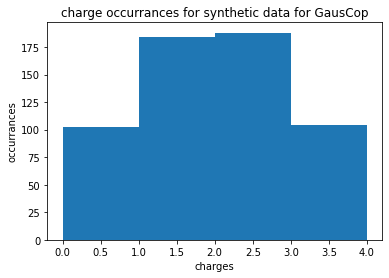

In [42]:
from matplotlib import pyplot as plt
#num_bins = 20
#group = [1000*i for i in range(13,65)]
#plt.hist(synth_data["charges"], group)
total01=len(synth_data["charges"])
ans01=[]
for i in range(4):
    num=len(synth_data["charges"][synth_data["charges"]==i])
    ans01.append(num/total01)
ans01=np.array(ans01)
print("The ratio of the synthetic data of charge >14000 is %.4f"%sum(ans01[14:]))
plt.title("charge occurrances for synthetic data for GausCop")
plt.xlabel("charges")
plt.ylabel("occurrances")
plt.hist(synth_data["charges"],bins=[i for i in range (5)])

From here we can see that the distribution of the charges is not so even.

Now this data can be fed into a new `setup` but this time declaring `test_data` as the test data that was created earlier. 

So there is a combination of **synthetic and real data in the training set** but only real in the test data.

In [43]:
# Run pycaret setup w/synthetic data
setup(data = mixed, 
      target = target, 
      test_data = test,
      train_size = 0.7, 
      numeric_features = cont_feats,
      categorical_features = cat_feats,
      ordinal_features = ord_feats,
      normalize_method = "zscore",
      ignore_low_variance = True,
      silent = True, verbose = False)

({'acc': <pycaret.containers.metrics.classification.AccuracyMetricContainer at 0x29911248d68>,
  'auc': <pycaret.containers.metrics.classification.ROCAUCMetricContainer at 0x29911248e48>,
  'recall': <pycaret.containers.metrics.classification.RecallMetricContainer at 0x29911222a90>,
  'precision': <pycaret.containers.metrics.classification.PrecisionMetricContainer at 0x29911222cf8>,
  'f1': <pycaret.containers.metrics.classification.F1MetricContainer at 0x29911222d68>,
  'kappa': <pycaret.containers.metrics.classification.KappaMetricContainer at 0x29911222a20>,
  'mcc': <pycaret.containers.metrics.classification.MCCMetricContainer at 0x29911222898>},
 0      4
 1      4
 2      2
 3      2
 4      3
       ..
 595    5
 596    0
 597    3
 598    4
 599    6
 Name: charges, Length: 1402, dtype: int64,
 'lightgbm',
 StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
 False,
 Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical

Now setup the `compare_models` can be checked again. Interestingly the `AUC`, `Recall` and `Precision` all went up considerably. `Recall` nearly doubled!

In [45]:
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.6060,0.0466,0.3858,0.5986,0.5947,0.4761,0.4786,0.2700
lr,Logistic Regression,0.5961,0.0601,0.3884,0.5902,0.5798,0.4602,0.4645,0.4470
lda,Linear Discriminant Analysis,0.5939,0.0577,0.3876,0.5884,0.5765,0.4577,0.4626,0.0110
rf,Random Forest Classifier,0.5790,0.0467,0.3759,0.5671,0.5685,0.4404,0.4422,0.1470
lightgbm,Light Gradient Boosting Machine,0.5711,0.0458,0.3835,0.5632,0.5612,0.4304,0.4323,0.1210
ridge,Ridge Classifier,0.5654,0.0000,0.3728,0.5611,0.5403,0.4223,0.4316,0.0140
et,Extra Trees Classifier,0.5547,0.0471,0.3610,0.5470,0.5449,0.4094,0.4116,0.1290
dt,Decision Tree Classifier,0.4784,0.0435,0.3251,0.4846,0.4770,0.3190,0.3206,0.0110
knn,K Neighbors Classifier,0.4527,0.0469,0.2891,0.4215,0.4183,0.2688,0.2755,0.0350
svm,SVM - Linear Kernel,0.3993,0.0000,0.2897,0.4651,0.3342,0.2169,0.2588,0.0260


GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=4593, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

A gradient boosting classifier was decided upon.

In [46]:
gbc = create_model("gbc")

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7730,0.0000,0.4589,0.7653,0.7651,0.6987,0.7015
1,0.8440,0.4665,0.4357,0.8221,0.8315,0.7928,0.7943
2,0.7071,0.0000,0.4129,0.6907,0.6980,0.6116,0.6125
3,0.8357,0.0000,0.5795,0.8237,0.8249,0.7830,0.7864
4,0.7429,0.0000,0.5107,0.7296,0.7302,0.6596,0.6625
5,0.6500,0.0000,0.4656,0.6284,0.6323,0.5373,0.5414
6,0.5286,0.0000,0.3210,0.5407,0.5287,0.3787,0.3809
7,0.3357,0.0000,0.1738,0.3640,0.3336,0.1214,0.1234
8,0.3000,0.0000,0.1708,0.2969,0.2841,0.0619,0.0633
9,0.3429,0.0000,0.3293,0.3245,0.3184,0.1161,0.1199


It may be a bug or something, but the AUC is close to zero, which is really absurd.

# **Second round**, Uniform

We will make the distribution uniform and see whether the result will be better.

In [60]:
best_score = 0 # Keep track of best score
# best_params=None
best_data = None
tracker = 0 # Keep track of how many loops have completed
flag = True
scores=[]

real = train # Filter to only those employees that left

import time
ST=time.time()

## TRAINING LOOP START ##
for _ in range(30): # only 1 and do the test

    # Increment the tracker
    tracker += 1
  
    # Every 5 loops output the tracker -> 1 loop
    print(tracker)



    # Record the hyperparameters and score      
    # proposal = tuner.propose(1)
  
    # NOTE - batch_size is multiplied by 10 as needs to be a factor of 10
    #model = GaussianCopula(constraints = [age_constraint, children_constraint, bmi_constraint, charges_constraint])
    model = GaussianCopula(constraints = [age_constraint, children_constraint, bmi_constraint])
    
    # Fit the CopulaGAN
    model.fit(real)
    # Create 600 rows of data
    synth_data = model.sample(num_rows = 1500)
  
    # Evaluate the synthetic data against the real data
    score = evaluate(synthetic_data = synth_data, real_data = real)
    scores.append(score)

    print(score)
    # If the new hyperparameters beat the best ones, store them along with the score
    if score > best_score or flag:
        flag = False
        best_data = synth_data
        best_distributions = model.get_distributions()
        # best_params = proposal
        best_score = score
  
    # Record the hyperparameters and score      
    # tuner.record(proposal, score)


## TRAINING LOOP END ##
ED=time.time()
print("time used: %.3f mins"%((ED-ST)/60))

1
0.5192231167197789
2
0.512397153536365
3
0.5109942855682802
4
0.5124488383809742
5
0.516891776041121
6
0.5203959025670112
7
0.5157818064957979
8
0.516760997774648
9
0.5120580811227247
10
0.5127543544189748
11
0.5161353254219141
12
0.5160013858809527
13
0.5167547664850638
14
0.5198698896761039
15
0.5167601734297779
16
0.5157246422507513
17
0.5159874762760889
18
0.5179772676094994
19
0.515041454825947
20
0.5158500728756348
21
0.5139820845721043
22
0.5173052474788871
23
0.5174736784884807
24
0.5159715721536718
25
0.513031185800251
26
0.5148230177098285
27
0.5169391127582087
28
0.5159433565445573
29
0.5157060890646536
30
0.5195035601676525
time used: 4.668 mins


In [74]:
best_data

,age,sex,bmi,children,smoker,region,charges
0,21,female,30.555791,2,no,northeast,2
4,61,male,32.373192,3,no,northeast,4
5,64,female,27.221246,1,no,northeast,3
7,41,male,19.619734,2,no,southeast,2
11,38,female,25.303828,1,no,southeast,4
...,...,...,...,...,...,...,...
1110,32,male,28.525828,1,no,southeast,2
1111,55,male,32.549936,1,no,southeast,2
1112,38,male,27.315941,2,no,southeast,0
2,52,male,28.128320,2,no,southwest,3


In [75]:
best_distributions

{'age': 'copulas.univariate.beta.BetaUnivariate',
 'bmi': 'copulas.univariate.gamma.GammaUnivariate',
 'children': 'copulas.univariate.student_t.StudentTUnivariate',
 'charges': 'copulas.univariate.gaussian.GaussianUnivariate',
 'sex#0': 'copulas.univariate.gaussian.GaussianUnivariate',
 'sex#1': 'copulas.univariate.gaussian.GaussianUnivariate',
 'smoker#0': 'copulas.univariate.gamma.GammaUnivariate',
 'smoker#1': 'copulas.univariate.log_laplace.LogLaplace',
 'region#0': 'copulas.univariate.gaussian.GaussianUnivariate',
 'region#1': 'copulas.univariate.log_laplace.LogLaplace',
 'region#2': 'copulas.univariate.gaussian.GaussianUnivariate',
 'region#3': 'copulas.univariate.log_laplace.LogLaplace'}

In [77]:
synth=[]
for i in range (4):
    orig_size=len(train[train["charges"]==i])
    synth_part=best_data[best_data["charges"]==i]
    generate=synth_part.sample(n=min(max(0,350-orig_size),len(synth_part)))
    print(len(generate))
    synth.append(generate)
synth=pd.concat(synth)
synth.sample(frac=1)

158
146
147
147


,age,sex,bmi,children,smoker,region,charges
420,23,female,27.164186,1,no,northeast,1
549,62,female,27.737840,1,no,southeast,2
423,20,female,31.827243,0,no,southeast,0
680,57,male,40.358183,3,no,southeast,2
19,30,female,35.815146,1,no,southeast,2
...,...,...,...,...,...,...,...
585,56,female,36.890872,1,no,southeast,1
1017,52,male,24.779865,1,no,southeast,2
793,55,male,40.533387,1,no,northeast,2
209,53,female,27.173503,2,no,southeast,1


In [78]:
score = evaluate(synthetic_data = synth, real_data = real, aggregate = False)
score

,metric,name,raw_score,normalized_score,min_value,max_value,goal
0,BNLogLikelihood,BayesianNetwork Log Likelihood,-2.298724,0.100387,-inf,0.0,MAXIMIZE
1,LogisticDetection,LogisticRegression Detection,0.356041,0.356041,0.0,1.0,MAXIMIZE
2,SVCDetection,SVC Detection,0.314227,0.314227,0.0,1.0,MAXIMIZE
11,GMLogLikelihood,GaussianMixture Log Likelihood,-4.279821,0.013656,-inf,inf,MAXIMIZE
12,CSTest,Chi-Squared,0.824931,0.824931,0.0,1.0,MAXIMIZE
13,KSTest,Inverted Kolmogorov-Smirnov D statistic,0.888340,0.888340,0.0,1.0,MAXIMIZE
14,KSTestExtended,Inverted Kolmogorov-Smirnov D statistic,0.844606,0.844606,0.0,1.0,MAXIMIZE
27,ContinuousKLDivergence,Continuous Kullback–Leibler Divergence,0.718006,0.718006,0.0,1.0,MAXIMIZE
28,DiscreteKLDivergence,Discrete Kullback–Leibler Divergence,0.703340,0.703340,0.0,1.0,MAXIMIZE


In [79]:
print(max(scores))
print(min(scores))

0.5203959025670112
0.5109942855682802


In [80]:
model.save('best_copula.pkl')

In [81]:
synth.to_csv("ins_synth_data_classifier_GC_unif.csv", index = False)

# **Testing performance for round 2**

In [82]:
# Load synth data in
synth_data2 = pd.read_csv("ins_synth_data_classifier_GC_unif.csv")

# Add the 600 synthetic rows of data to training data + remove dataset column
mixed = pd.concat([train, synth_data2])

In [83]:
mixed

,age,sex,bmi,children,smoker,region,charges
0,59,female,27.720000,3,no,southeast,2
1,60,male,25.740000,0,no,southeast,2
2,28,female,34.770000,0,no,northwest,0
3,19,female,28.400000,1,no,southwest,0
4,45,male,27.500000,3,no,southwest,1
...,...,...,...,...,...,...,...
593,29,female,31.285989,2,no,southeast,3
594,29,male,21.415902,3,no,northeast,3
595,52,female,43.630585,0,no,southeast,3
596,41,female,34.799350,2,no,southeast,3


In [84]:
print("Training size (real):", train.shape)
print("Training size (fake + real):", mixed.shape)
print("Testing size (real:", test.shape)

Training size (real): (802, 7)
Training size (fake + real): (1400, 7)
Testing size (real: (536, 7)


Now this data can be fed into a new `setup` but this time declaring `test_data` as the test data that was created earlier. 

So there is a combination of **synthetic and real data in the training set** but only real in the test data.

In [85]:
# Run pycaret setup w/synthetic data
setup(data = mixed, 
      target = "charges", 
      test_data = test,
      train_size = 0.7, 
      numeric_features = cont_feats,
      categorical_features = cat_feats,
      ordinal_features = ord_feats,
      normalize_method = "zscore",
      ignore_low_variance = True,
      silent = True, verbose = False)

({'acc': <pycaret.containers.metrics.classification.AccuracyMetricContainer at 0x299124a2c50>,
  'auc': <pycaret.containers.metrics.classification.ROCAUCMetricContainer at 0x299124a20f0>,
  'recall': <pycaret.containers.metrics.classification.RecallMetricContainer at 0x299124a2860>,
  'precision': <pycaret.containers.metrics.classification.PrecisionMetricContainer at 0x299124a2828>,
  'f1': <pycaret.containers.metrics.classification.F1MetricContainer at 0x299124a24a8>,
  'kappa': <pycaret.containers.metrics.classification.KappaMetricContainer at 0x299124a2780>,
  'mcc': <pycaret.containers.metrics.classification.MCCMetricContainer at 0x299124a2cc0>},
 0      2
 1      2
 2      0
 3      0
 4      1
       ..
 593    3
 594    3
 595    3
 596    3
 597    3
 Name: charges, Length: 1400, dtype: int64,
 'lightgbm',
 StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
 False,
 Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical

Now setup the `compare_models` can be checked again. Interestingly the `AUC`, `Recall` and `Precision` all went up considerably. `Recall` nearly doubled!

In [86]:
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.6164,0.8009,0.6164,0.6334,0.6146,0.4886,0.4909,0.1520
ada,Ada Boost Classifier,0.6093,0.7372,0.6093,0.6341,0.6004,0.4790,0.4828,0.0340
lr,Logistic Regression,0.5943,0.7940,0.5943,0.6072,0.5830,0.4590,0.4629,0.1400
rf,Random Forest Classifier,0.5914,0.7833,0.5914,0.5978,0.5913,0.4552,0.4561,0.1470
lda,Linear Discriminant Analysis,0.5893,0.7950,0.5893,0.6394,0.5756,0.4524,0.4582,0.0110
lightgbm,Light Gradient Boosting Machine,0.5764,0.7802,0.5764,0.5807,0.5750,0.4352,0.4363,0.0760
ridge,Ridge Classifier,0.5643,0.0000,0.5643,0.6133,0.5382,0.4190,0.4295,0.0110
et,Extra Trees Classifier,0.5621,0.7719,0.5621,0.5657,0.5611,0.4162,0.4170,0.1360
dt,Decision Tree Classifier,0.5029,0.6686,0.5029,0.5073,0.5016,0.3371,0.3385,0.0120
nb,Naive Bayes,0.4736,0.7521,0.4736,0.4491,0.4088,0.2981,0.3341,0.0100


GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=3363, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

We decided to use gradient boost classifier

In [87]:
gbc = create_model("gbc")

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8500,0.9637,0.8500,0.8557,0.8510,0.8000,0.8013
1,0.8214,0.9483,0.8214,0.8285,0.8214,0.7619,0.7644
2,0.7857,0.9111,0.7857,0.7886,0.7842,0.7143,0.7160
3,0.8357,0.9399,0.8357,0.8361,0.8331,0.7810,0.7827
4,0.8143,0.9404,0.8143,0.8135,0.8127,0.7524,0.7531
5,0.6643,0.8539,0.6643,0.6742,0.6643,0.5524,0.5555
6,0.4286,0.6629,0.4286,0.4673,0.4328,0.2381,0.2423
7,0.2857,0.5876,0.2857,0.3011,0.2734,0.0476,0.0498
8,0.3857,0.6463,0.3857,0.4410,0.3851,0.1810,0.1855
9,0.2929,0.5543,0.2929,0.3280,0.2876,0.0571,0.0586


# **Third round**, Use different distribution

There's a useful library `sdev` [Synthetic Data Generation](https://github.com/sdv-dev/SDV) to generate synthetic tabular data. I've played around with it specifically the `CopulaGAN` model.

The general idea is to provide a `primary key` and to then run the model for so many `epochs`. There are hyperparameters to tune
* `epochs`
* `batch_size`
* `embedding_dim`
* `gen_dim`
* `dis_dim`
* `l2scale` (omitted in this experiment)



Rather than running a CopulaGAN without hyperparameters or guessing hyperparameters I've leveraged `BTB` [Bayesian Tuning and Bandits](https://github.com/MLBazaar/BTB) which is an optimisation library. To start I'll initialise the `GCPTuner` which is used to declare the hyperparameters to tune. Then the hyperparameters can be called using `propose` from BTB.

In [88]:
tuner = GCPTuner(Tunable({
          'epochs': hp.IntHyperParam(min = 80, max = 400),
          'batch_size' : hp.IntHyperParam(min = 1, max = 100),
          'embedding_dim' : hp.IntHyperParam(min = 1, max = 100),
          'gen' : hp.IntHyperParam(min = 1, max = 1000),
          'dim_gen' : hp.IntHyperParam(min = 1, max = 1000)
        }))

In [89]:
best_score = 0 # Keep track of best score
# best_params=None
best_data = None
tracker = 0 # Keep track of how many loops have completed
flag = True
scores=[]

real = train # Filter to only those employees that left

import time
ST=time.time()

## TRAINING LOOP START ##
for _ in range(30): # only 1 and do the test

    # Increment the tracker
    tracker += 1
  
    # Every 5 loops output the tracker -> 1 loop
    print(tracker)



    # Record the hyperparameters and score      
    proposal = tuner.propose(1)
  
    # NOTE - batch_size is multiplied by 10 as needs to be a factor of 10
    #model = GaussianCopula(constraints = [age_constraint, children_constraint, bmi_constraint])
    model = GaussianCopula(
                    
                    constraints = [age_constraint, children_constraint, bmi_constraint])
    
    # Fit the CopulaGAN
    model.fit(real)
    # Create 600 rows of data
    synth_data = model.sample(num_rows = 1500)
  
    # Evaluate the synthetic data against the real data
    score = evaluate(synthetic_data = synth_data, real_data = real)
    scores.append(score)

    print(score)
    # If the new hyperparameters beat the best ones, store them along with the score
    if score > best_score or flag:
        flag = False
        best_data = synth_data
        best_distributions = model.get_distributions()
        # best_params = proposal
        best_score = score
  
    # Record the hyperparameters and score      
    # tuner.record(proposal, score)


## TRAINING LOOP END ##
ED=time.time()
print("time used: %.3f mins"%((ED-ST)/60))

1


TypeError: __init__() got an unexpected keyword argument 'embedding_dim'

In [ ]:
best_data

In [ ]:
best_distributions

In [ ]:
best=best_data
best_data=best_data[~best_data.index.duplicated()]
num_bins = 20
plt.hist(best_data["charges"], [i for i in range (5)])

In [ ]:
score = evaluate(synthetic_data = best_data, real_data = real, aggregate = False)
score

In [ ]:
synth=[]
for i in range (4):
    orig_size=len(train[train["charges"]==i])
    synth_part=best_data[best_data["charges"]==i]
    generate=synth_part[:140]
    synth.append(generate)
synth=pd.concat(synth)
synth.sample(frac=1)

In [ ]:
score = evaluate(synthetic_data = synth, real_data = train, aggregate = True)
score

In [ ]:
print('Best score obtained: ', best_score)

In [ ]:
print(max(scores))
print(min(scores))

In [ ]:
model.save('best_copula.pkl')

In [ ]:
synth.to_csv("ins_synth_GC_norm_CF.csv", index = False)
best_data.to_csv("ins_synth_GC_CF.csv", index = False)

# **Setting up data for round 2**
The real dataset can be split into 60:40 training/test. Once this has been split the synthetic data can be added to the training data. This in a way doesn't "waste" the real dataset in the training.

In [ ]:
# Load synth data in
synth_data2 = pd.read_csv("ins_synth_GC_CF.csv")

# Add the 600 synthetic rows of data to training data + remove dataset column
mixed = pd.concat([train, synth_data2])

In [ ]:
mixed

In [ ]:
print("Training size (real):", train.shape)
print("Training size (fake + real):", mixed.shape)
print("Testing size (real:", test.shape)

Now this data can be fed into a new `setup` but this time declaring `test_data` as the test data that was created earlier. 

So there is a combination of **synthetic and real data in the training set** but only real in the test data.

In [ ]:
# Run pycaret setup w/synthetic data
setup(data = mixed, 
      target = "charges", 
      test_data = test,
      train_size = 0.7, 
      numeric_features = cont_feats,
      categorical_features = cat_feats,
      ordinal_features = ord_feats,
      normalize_method = "zscore",
      ignore_low_variance = True,
      silent = True, verbose = False)

Now setup the `compare_models` can be checked again. Interestingly the `AUC`, `Recall` and `Precision` all went up considerably. `Recall` nearly doubled!

In [ ]:
compare_models()

A gradient boosting classifier was decided upon.

In [ ]:
par = create_model("par")

# **Finalising the model**
Now with the model trained and evaluated it needs to be **finalised**. This encorporates the test data into the model that will be used on unseen data.

In [ ]:
final_gbc = finalize_model(huber)

**NOTE**: I haven't further explored the model e.g. feature importance as the purpose of this project was to focus on synthetic data generation and a streamlit app.

# **Saving and exporting ready for app build**
To use the model in a `streamlit` app certain things need to be exported
* The model
* Preprocessed data
* Preparation steps (`prep pipe`)

In [ ]:
# Model (save)
save_model(final_gbc, "final_gbc")

# Preparation steps (get + save)
prep = get_config("prep_pipe")
joblib.dump(prep, 'prep_pipe.pkl', compress = 1)

# Preprocessed data (get + save)
get_config("X").to_csv("preprocssed_data.csv", index = False)

# **Streamlit app**
The final output of this was a `streamlit` app to allow single predictions w/reason plots or multi predictions from an uploaded csv (see `README.md` and `app.py`).

# **Conclusion**
I think that synthetic data generation can be a powerful tool especially in situations when further data collection cannot be performed in the near term. Fine tuning hyperparameters is great to have but more data and feature engineering are still superior.

In [ ]:
# any random test
import random
# give a data of 20% 0-100, 40% 100-200, 30% 200-300,10% 300-400, 
small=[[100*random.random()] for _ in range (400)]
medium=[[100+100*random.random()] for _ in range (800)]
large=[[200+100*random.random()] for _ in range (600)]
extralarge=[[300+100*random.random()] for _ in range (200)]
mix=small+medium+large+extralarge
random.shuffle(mix)
df = pd.DataFrame(mix, columns=["s"])
final_ans=[]
for _ in range (200):
    toy_ans = list()
    model = GaussianCopula()
    model.fit(df)
    synth = model.sample(num_rows = 2000)
    for i in range(4):
        num=len(synth["s"][synth["s"]<(i+1)*100][synth["s"]>=i*100])
        toy_ans.append(num/2000)
    final_ans.append(toy_ans)
final_ans

In [ ]:
plt.hist(np.array(mix),bins=np.array([10*i for i in range(41)]))

In [ ]:
arr=np.array(final_ans)
trans_arr=np.transpose(arr)
plt.hist(trans_arr[3],bins=np.array([i/500 for i in range (38,55)]))

In [ ]:
plt.hist(trans_arr[2],bins=np.array([i/500 for i in range (140,169)]))

In [ ]:
plt.hist(trans_arr[1],bins=np.array([i/500 for i in range (179,207)]))

In [ ]:
plt.hist(trans_arr[0],bins=np.array([i/500 for i in range (75,99)]))